In [1]:
import os
HOME = os.getcwd()
print(HOME)

/data/tphuawir/move/DETR


## use in final

In [2]:
import os
import torchvision
import torch
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
dataset = '../../DETR/datasets/MedicineBoxes-1'
# Settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

# Define the characters you're recognizing (adapt to your dataset)
CHARS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 -.,'
CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}  # Map characters to labels
LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}  # Map labels back to characters

def convert_bbox_tocrop(box):
        """function convert bbox from annotation or prediction
        bbox format = [x_min, y_min, width, height] 
        crop area = [x_min, y_min, x_max, y_max]
        input box: list
        return crop_area: list
        """
        x_min = box[0]
        y_min = box[1]
        width = box[2]
        height = box[3]
        x_max = x_min + width
        y_max = y_min + height
        crop_area = [x_min, y_min, x_max, y_max]
        return crop_area
    
class CocoCRNNDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, img_height=32, img_width=100, train=True, bbox_predictions=None):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoCRNNDataset, self).__init__(image_directory_path, annotation_file_path)
        self.img_height = img_height
        self.img_width = img_width
        self.bbox_predictions = bbox_predictions  # Store predicted bounding boxes

    def __getitem__(self, idx):
        # Get image and annotations using the parent class
        image, annotations = super(CocoCRNNDataset, self).__getitem__(idx)
        
        if annotations and 'bbox' in annotations[0]:
            bbox = annotations[0]['bbox']
            crop_bbox = convert_bbox_tocrop(bbox)
            image = image.crop(crop_bbox)
            # print("bbox", bbox)
            # print("crop_bbox", crop_bbox)

            
        # If bounding box predictions are provided, crop the image accordingly
        if self.bbox_predictions and idx in self.bbox_predictions:
            bbox = self.bbox_predictions[idx]  # Format: [x_min, y_min, width, height]
            crop_bbox = convert_bbox_tocrop(bbox)
            image = image.crop(crop_bbox)
            # print("bbox", bbox)
            # print("crop_bbox", crop_bbox)
        # plt.imshow(image)
        # plt.axis("off")
        # plt.show()

        # Resize the cropped image and convert to grayscale for CRNN input
        image = image.convert('RGB')  # Convert to grayscale
        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)  # Convert image to numpy array
        # image = image.reshape((1, self.img_height, self.img_width))  # Add channel dimension
        # Transpose the dimensions to (channels, height, width)
        image = image.transpose((2, 0, 1))
        image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
        image = torch.FloatTensor(image)  # Convert to tensor

        # Extract text labels from annotations (adapt this based on your dataset structure)
        if annotations and 'category_id' in annotations[0]:
            category_id = annotations[0]['category_id']
            text = str(category_id)  # Convert category_id to a string
        else:
            text = 'unknown'

        # Convert text to a sequence of label indices
        target = [CHAR2LABEL.get(c, 0) for c in text if c in CHAR2LABEL]
        target_length = [len(target)]  # Length of the target sequence

        # Convert target and target length to tensor
        target = torch.LongTensor(target)
        target_length = torch.LongTensor(target_length)

        return image, target, target_length



# Custom collate function for batching
def coco_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths


MODEL_PATH = os.path.join(HOME, 'custom-model')
from transformers import DetrImageProcessor




# Create datasets and dataloaders
train_dataset = CocoCRNNDataset(
    image_directory_path=TRAIN_DIRECTORY,
    train=True)

val_dataset = CocoCRNNDataset(
    image_directory_path=VAL_DIRECTORY,
    train=False)

test_dataset = CocoCRNNDataset(
    image_directory_path=TEST_DIRECTORY,
    train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=coco_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)

# Check dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 2661
Number of validation examples: 157
Number of test examples: 41


## sample

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


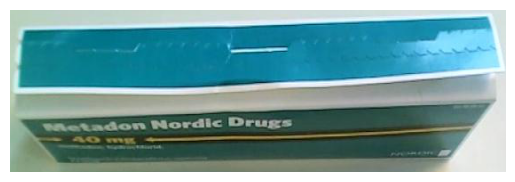

In [18]:
import matplotlib.pyplot as plt

# Manually access a specific index to trigger __getitem__ and display the cropped image
train_dataset = CocoCRNNDataset(
    image_directory_path=TRAIN_DIRECTORY,
    train=True)

# Pick a specific index to view, for example, index 0
image, text, _ = train_dataset[90]  # This will call __getitem__ and display the cropped image


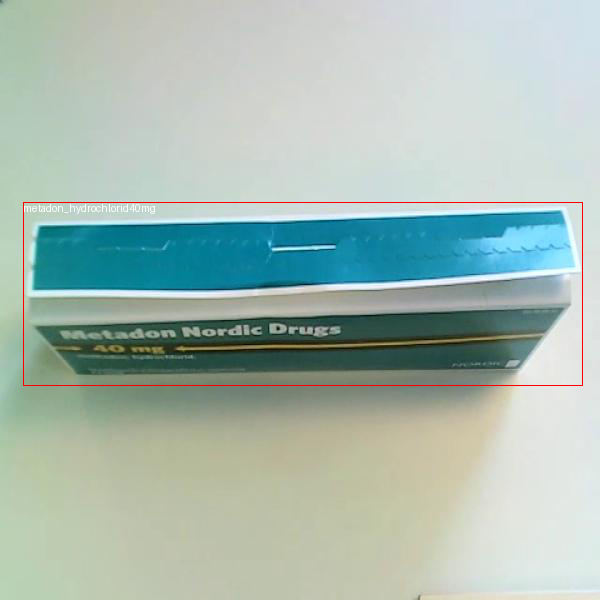

In [16]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = 90
# print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(os.path.join(dataset, "train"), image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

## Simplified Dataset Class for Training with Bounding Boxes

In [19]:
import os
import json
import torch
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

# Define the characters you're recognizing (adapt to your dataset)
CHARS = '0123456789abcdefghijklmnopqrstuvwxyz'
CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}  # Map characters to labels
LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}  # Map labels back to characters

class CocoCroppedDataset(Dataset):
    def __init__(self, image_directory, annotation_file, img_height=32, img_width=100):
        self.image_directory = image_directory
        self.img_height = img_height
        self.img_width = img_width
        
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        
        # Extract images and annotations
        self.image_info = {img['id']: img for img in self.annotations['images']}
        self.annotations_map = {img_id: [] for img_id in self.image_info.keys()}
        
        # Map annotations to images
        for ann in self.annotations['annotations']:
            self.annotations_map[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        # Get image information
        image_info = list(self.image_info.values())[idx]
        image_id = image_info['id']
        image_path = os.path.join(self.image_directory, image_info['file_name'])

        # Load image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        
        # Get bounding boxes for this image
        annotations = self.annotations_map[image_id]
        
        cropped_images = []
        targets = []
        
        for ann in annotations:
            # Extract bounding box (x_min, y_min, width, height)
            bbox = ann['bbox']  # Format: [x_min, y_min, width, height]
            x_min, y_min, width, height = map(int, bbox)
            x_max, y_max = x_min + width, y_min + height
            
            # Crop image using bounding box
            cropped_image = image.crop((x_min, y_min, x_max, y_max))
            cropped_image = cropped_image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
            cropped_image = np.array(cropped_image) / 127.5 - 1.0  # Normalize to [-1, 1]
            cropped_image = torch.FloatTensor(cropped_image).unsqueeze(0)  # Add channel dimension
            
            # Get category label
            if annotations and 'category_id' in annotations[0]:
            category_id = annotations[0]['category_id']
            text = str(category_id)  # Convert category_id to a string
        else:
            text = 'unknown'

            category_id = ann['category_id']
            category_name = next((cat['name'] for cat in self.annotations['categories'] if cat['id'] == category_id), 'unknown')
            
            # Convert category name to a sequence of label indices (if applicable)
            target = [CHAR2LABEL.get(c, 0) for c in category_name if c in CHAR2LABEL]
            target_length = [len(target)]
            
            # Convert target and target length to tensor
            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)

            # Append cropped image and targets to the lists
            cropped_images.append(cropped_image)
            targets.append((target, target_length))

        # Stack cropped images and targets for batch processing
        images_tensor = torch.stack(cropped_images, dim=0)
        targets_tensor, target_lengths_tensor = zip(*targets)

        return images_tensor, torch.cat(targets_tensor), torch.cat(target_lengths_tensor)

# Example usage
dataset_path = '../../DETR/datasets/MedicineBoxes-1'
annotation_file = os.path.join(dataset_path, 'train', '_annotations.coco.json')
image_directory = os.path.join(dataset_path, 'train')

# Create the dataset
cropped_dataset = CocoCroppedDataset(image_directory=image_directory, annotation_file=annotation_file)

# Example DataLoader
from torch.utils.data import DataLoader

def coco_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.cat(images, 0)  # Concatenate images
    targets = torch.cat(targets, 0)  # Concatenate targets
    target_lengths = torch.cat(target_lengths, 0)  # Concatenate target lengths
    return images, targets, target_lengths

train_loader = DataLoader(cropped_dataset, batch_size=32, shuffle=True, collate_fn=coco_collate_fn)

# Check dataset size
print("Number of training examples:", len(cropped_dataset))


Number of training examples: 2661


In [20]:
class CocoCroppedValTestDataset(Dataset):
    def __init__(self, image_directory, annotation_file, img_height=32, img_width=100):
        self.image_directory = image_directory
        self.img_height = img_height
        self.img_width = img_width
        
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        
        # Extract images and annotations
        self.image_info = {img['id']: img for img in self.annotations['images']}
        self.annotations_map = {img_id: [] for img_id in self.image_info.keys()}
        
        # Map annotations to images
        for ann in self.annotations['annotations']:
            self.annotations_map[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        # Get image information
        image_info = list(self.image_info.values())[idx]
        image_id = image_info['id']
        image_path = os.path.join(self.image_directory, image_info['file_name'])

        # Load image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        
        # Get bounding boxes for this image
        annotations = self.annotations_map[image_id]
        
        cropped_images = []
        targets = []
        
        for ann in annotations:
            # Extract bounding box (x_min, y_min, width, height)
            bbox = ann['bbox']  # Format: [x_min, y_min, width, height]
            x_min, y_min, width, height = map(int, bbox)
            x_max, y_max = x_min + width, y_min + height
            
            # Crop image using bounding box
            cropped_image = image.crop((x_min, y_min, x_max, y_max))
            cropped_image = cropped_image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
            cropped_image = np.array(cropped_image) / 127.5 - 1.0  # Normalize to [-1, 1]
            cropped_image = torch.FloatTensor(cropped_image).unsqueeze(0)  # Add channel dimension
            
            # Get category label
            category_id = ann['category_id']
            category_name = next((cat['name'] for cat in self.annotations['categories'] if cat['id'] == category_id), 'unknown')
            
            # Convert category name to a sequence of label indices (if applicable)
            target = [CHAR2LABEL.get(c, 0) for c in category_name if c in CHAR2LABEL]
            target_length = [len(target)]
            
            # Convert target and target length to tensor
            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)

            # Append cropped image and targets to the lists
            cropped_images.append(cropped_image)
            targets.append((target, target_length))

        # Stack cropped images and targets for batch processing
        images_tensor = torch.stack(cropped_images, dim=0)
        targets_tensor, target_lengths_tensor = zip(*targets)

        return images_tensor, torch.cat(targets_tensor), torch.cat(target_lengths_tensor)

# Usage for validation and test datasets would be similar to the training dataset
val_annotation_file = os.path.join(dataset_path, 'valid', '_annotations.coco.json')
test_annotation_file = os.path.join(dataset_path, 'test', '_annotations.coco.json')

val_image_directory = os.path.join(dataset_path, 'valid')
test_image_directory = os.path.join(dataset_path, 'test')

val_dataset = CocoCroppedValTestDataset(image_directory=val_image_directory, annotation_file=val_annotation_file)
test_dataset = CocoCroppedValTestDataset(image_directory=test_image_directory, annotation_file=test_annotation_file)

# Create DataLoaders for validation and test datasets
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)

# Check validation and test dataset size
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))


Number of validation examples: 157
Number of test examples: 41


# Model

## custom

In [5]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class CRNNTransferLearning(nn.Module):

#     def __init__(self, img_channel, img_height, img_width, num_class,
#                  map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
#         super(CRNNTransferLearning, self).__init__()

#         self.cnn, output_channel = self._cnn_backbone()

#         # Assuming the image size is fixed, adjust based on the output size of the pre-trained model
#         output_height, output_width = img_height // 32, img_width // 32

#         self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

#         self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True, dropout=0.5, batch_first=True)
#         self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True, dropout=0.5, batch_first=True)

#         self.dense = nn.Linear(2 * rnn_hidden, num_class)

#     def _cnn_backbone(self):
#         # Use a pre-trained ResNet model for transfer learning
#         resnet = models.resnet18(pretrained=True)

#         # Modify the ResNet to remove the last fully connected layer (since we are using it as a feature extractor)
#         modules = list(resnet.children())[:-2]  # Remove the last layer (fc) and avgpool layer

#         cnn = nn.Sequential(*modules)

#         output_channel = 512  # ResNet-18 has 512 output channels before the fully connected layer
#         return cnn, output_channel

#     def forward(self, images):
#         # Check if the image has 1 channel and repeat to 3 channels
#         if images.shape[1] == 1:
#             images = images.repeat(1, 3, 1, 1)  # Repeat channels for grayscale images
    
#         # shape of images: (batch, channel, height, width)
#         conv = self.cnn(images)  # Forward through the CNN
#         batch, channel, height, width = conv.size()
    
#         conv = conv.view(batch, channel * height, width)  # Reshape for RNN input
#         conv = conv.permute(2, 0, 1)  # (width, batch, feature)
#         seq = self.map_to_seq(conv)  # Map to sequence hidden size
    
#         recurrent, _ = self.rnn1(seq)  # Pass through first LSTM
#         recurrent, _ = self.rnn2(recurrent)  # Pass through second LSTM
    
#         output = self.dense(recurrent)  # Final dense layer output
#         return output  # shape: (seq_len, batch, num_class)


## transfer

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class CRNNTransferLearning(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNNTransferLearning, self).__init__()
        self.num_class = num_classes + 1 
        self.cnn, output_channel = self._cnn_backbone()

        # Assuming the image size is fixed, adjust based on the output size of the pre-trained model
        output_height, output_width = img_height // 32, img_width // 32

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True, dropout=0.5, batch_first=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True, dropout=0.5, batch_first=True)

        
        self.dense = nn.Linear(2 * rnn_hidden, self.num_class)

    def _cnn_backbone(self):
        # Use a pre-trained ResNet model for transfer learning
        resnet = models.resnet18(pretrained=True)

        # Modify the ResNet to remove the last fully connected layer (since we are using it as a feature extractor)
        modules = list(resnet.children())[:-2]  # Remove the last layer (fc) and avgpool layer
        modules.append(nn.BatchNorm2d(512))
        cnn = nn.Sequential(*modules)

        output_channel = 512  # ResNet-18 has 512 output channels before the fully connected layer
        return cnn, output_channel

    def forward(self, images):
        # Check if the image has 1 channel and repeat to 3 channels
        # if images.shape[1] == 1:
        #     images = images.repeat(1, 3, 1, 1)  # Repeat channels for grayscale images
    
        # shape of images: (batch, channel, height, width)
        conv = self.cnn(images)  # Forward through the CNN
        batch, channel, height, width = conv.size()
    
        conv = conv.view(batch, channel * height, width)  # Reshape for RNN input
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)  # Map to sequence hidden size
    
        recurrent, _ = self.rnn1(seq)  # Pass through first LSTM
        recurrent, _ = self.rnn2(recurrent)  # Pass through second LSTM
    
        output = self.dense(recurrent)  # Final dense layer output
        return output  # shape: (seq_len, batch, num_class)


In [4]:
import sys
print(sys.path)
sys.path.append('/home/tphuawir/Documents/DETR')

['/data/tphuawir/move/DETR', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/home/tphuawir/.local/lib/python3.11/site-packages', '/opt/conda/lib/python3.11/site-packages']


In [5]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import CTCLoss
from torchvision import transforms
from tqdm import tqdm
import Levenshtein
import torchmetrics
from torchmetrics import CharErrorRate, WordErrorRate
from ctc_decoder import ctc_decode

In [6]:
# Evaluation function
def evaluate(crnn, dataloader, criterion,
             max_iter=None, decode_method='beam_search', beam_size=10):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate")

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets, target_lengths = [d.to(device) for d in data]

            logits = crnn(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size).to(device)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)

            preds = ctc_decode(log_probs, method=decode_method, beam_size=beam_size)
            reals = targets.cpu().numpy().tolist()
            target_lengths = target_lengths.cpu().numpy().tolist()

            tot_count += batch_size
            tot_loss += loss.item()
            target_length_counter = 0
            for pred, target_length in zip(preds, target_lengths):
                real = reals[target_length_counter:target_length_counter + target_length]
                target_length_counter += target_length
                if pred == real:
                    tot_correct += 1
                else:
                    wrong_cases.append((real, pred))

            pbar.update(1)
        pbar.close()

    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': tot_correct / tot_count,
        'wrong_cases': wrong_cases
    }
    return evaluation

In [7]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()  # Set the model to training mode

    # Move images, targets, and target lengths to the correct device (CPU or GPU)
    images, targets, target_lengths = [d.to(device) for d in data]

    # Forward pass: images go through the STN + CRNN pipeline
    logits = crnn(images)  # logits: (seq_len, batch_size, num_classes)

    # Compute log probabilities for CTC loss
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    # Prepare input and target lengths for CTC loss
    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size).to(device)
    target_lengths = torch.flatten(target_lengths)

    # Compute the CTC loss
    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    # Backpropagation and optimization step
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping to avoid exploding gradients
    # torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 1)

    # Update the model parameters
    optimizer.step()

    # Return the loss value for logging
    return loss.item()

In [8]:
show_interval = 10
valid_interval = 500
save_interval = 2000
decode_method = 'beam_search'
beam_size = 5
checkpoints_dir = 'crnn_checkpoints/beam_search/exp2'
epochs = 300
lr = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CRNN model
num_classes = len(CHARS) + 1  # Include 1 for the CTC blank character
crnn = CRNNTransferLearning(img_channel=1, img_height=32, img_width=100, 
                   num_class=num_classes, map_to_seq_hidden=64, 
                   rnn_hidden=768, leaky_relu=False).to(device)

# optimizer = optim.RMSprop(crnn.parameters(), lr=lr)
optimizer = torch.optim.Adam(crnn.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                       patience=5, verbose=True)



criterion = CTCLoss(reduction='mean', zero_infinity=True)
criterion.to(device)
# DataLoader setup (reuse the DataLoader setup from your code)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=coco_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=coco_collate_fn)

show_interval = 10
valid_interval = 500
save_interval = 2000
decode_method = 'beam_search'
beam_size = 5
checkpoints_dir = 'crnn_checkpoints/'
epochs = 300
lr = 0.0005
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()  # Set the model to training mode

    # Move images, targets, and target lengths to the correct device (CPU or GPU)
    images, targets, target_lengths = [d.to(device) for d in data]

    # Forward pass: images go through the STN + CRNN pipeline
    logits = crnn(images)  # logits: (seq_len, batch_size, num_classes)

    # Compute log probabilities for CTC loss
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    # Prepare input and target lengths for CTC loss
    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size).to(device)
    target_lengths = torch.flatten(target_lengths)

    # Compute the CTC loss
    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    # Backpropagation and optimization step
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping to avoid exploding gradients
    # torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), max_norm=5.0)

    # Update the model parameters
    optimizer.step()

    # Return the loss value for logging
    return loss.item()
    

    

best_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 10 
i = 0
# Training loop
for epoch in range(1, epochs + 1):
    print(f'epoch: {epoch}')
    tot_train_loss = 0.
    tot_train_count = 0
    for train_data in train_loader:
        loss = train_batch(crnn, train_data, optimizer, criterion, device)
        train_size = train_data[0].size(0)

        tot_train_loss += loss
        tot_train_count += train_size
        if i % show_interval == 0:
            print('train_batch_loss[', i, ']: ', loss / train_size)

        if i % valid_interval == 0:
            evaluation = evaluate(crnn, val_loader, criterion,
                                  decode_method=decode_method,
                                  beam_size=beam_size)
            val_loss, val_acc = evaluation['loss'], evaluation['acc']
            print('valid_evaluation: loss={loss}, acc={acc}'.format(**evaluation))
            if val_loss < best_loss:
                best_loss = val_loss
                early_stop_counter = 0
                # Save the best model
                torch.save(crnn.state_dict(), f'{checkpoints_dir}/best_model.pt')
            else:
                early_stop_counter += 1
            scheduler.step(val_loss) 
            if early_stop_counter >= early_stop_patience:
                print("Early stopping.")
                break

            if i % save_interval == 0:
                prefix = 'crnn'
                loss = evaluation['loss']
                save_model_path = os.path.join(checkpoints_dir,
                                               f'{prefix}_{i:06}_loss{loss}.pt')
                torch.save(crnn.state_dict(), save_model_path)
                print('save model at ', save_model_path)

        i += 1

    print('train_loss: ', tot_train_loss / tot_train_count)

/home/tphuawir/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tphuawir/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/tphuawir/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/tphuawir/.local/lib/python3.11/site

epoch: 1
train_batch_loss[ 0 ]:  0.5315492749214172


Evaluate: 100%|█████████████████████████████████████████████| 20/20 [00:00<00:00, 22.06it/s]


valid_evaluation: loss=1.1528426006341437, acc=0.0
save model at  crnn_checkpoints/crnn_000000_loss1.1528426006341437.pt
train_batch_loss[ 10 ]:  0.5343500971794128
train_batch_loss[ 20 ]:  0.3735836148262024
train_batch_loss[ 30 ]:  0.24117213487625122
train_batch_loss[ 40 ]:  0.17935702204704285
train_batch_loss[ 50 ]:  0.16350063681602478
train_batch_loss[ 60 ]:  0.15967527031898499
train_batch_loss[ 70 ]:  0.15249943733215332
train_batch_loss[ 80 ]:  0.15074247121810913
train_batch_loss[ 90 ]:  0.14864690601825714
train_batch_loss[ 100 ]:  0.14047619700431824
train_batch_loss[ 110 ]:  0.14516274631023407
train_batch_loss[ 120 ]:  0.1351962387561798
train_batch_loss[ 130 ]:  0.1457265019416809
train_batch_loss[ 140 ]:  0.12457669526338577
train_batch_loss[ 150 ]:  0.14103257656097412
train_batch_loss[ 160 ]:  0.12647156417369843
train_loss:  0.20857252244974428
epoch: 2
train_batch_loss[ 170 ]:  0.1332506537437439
train_batch_loss[ 180 ]:  0.11943379789590836
train_batch_loss[ 190 ]

Evaluate: 100%|█████████████████████████████████████████████| 20/20 [00:00<00:00, 34.09it/s]


valid_evaluation: loss=0.17497059607961377, acc=0.4140127388535032
train_loss:  0.0856249372074811
epoch: 4
train_batch_loss[ 510 ]:  0.06381266564130783
train_batch_loss[ 520 ]:  0.05946480110287666
train_batch_loss[ 530 ]:  0.059472329914569855
train_batch_loss[ 540 ]:  0.08056424558162689
train_batch_loss[ 550 ]:  0.07108810544013977
train_batch_loss[ 560 ]:  0.04558398574590683


KeyboardInterrupt: 

In [49]:
model_save_path = 'tl_model'

torch.save(crnn.state_dict(), os.path.join(model_save_path, 'tl_crnn_model2.pth'))

In [50]:
import torch


# Create a TorchScript version of the model
scripted_model = torch.jit.script(crnn)

# Save the scripted model
scripted_model.save('jit_tl_crnn_model2.pth')

Evaluate:  20%|████████▏                                | 1/5 [1:08:03<4:32:13, 4083.45s/it]


In [26]:
# # Save the model after training is complete
# model_save_path = 'tl_model/2_crnn_300'
# torch.save({
#     'epoch': epochs,  # Save the final epoch number
#     'model_state_dict': crnn.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),  # Optional: save optimizer state
# }, model_save_path)

# print(f'Model saved to {model_save_path}')

In [55]:
# Create a new instance of your model
model_save_path = 'tl_model/tl_crnn_model2.pth'
lr = 0.0005
CHARS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 -.,'

num_classes = len(CHARS) + 1  # Include 1 for CTC blank
crnn = CRNNTransferLearning(img_channel=1, img_height=32, img_width=100, 
                   num_class=num_classes, map_to_seq_hidden=64, 
                   rnn_hidden=768, leaky_relu=False).to(device)
criterion = SmoothCTCLoss(smoothing=0.1).to(device)

optimizer = torch.optim.Adam(crnn.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Load the model state dict

crnn.load_state_dict(torch.load(model_save_path))
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If you saved optimizer state
crnn.to(device)
crnn.eval()
# Perform evaluation
evaluation = evaluate(crnn, val_loader, criterion, 
                      decode_method=decode_method, beam_size=beam_size)

# Extract evaluation metrics
val_loss = evaluation['loss']
val_acc = evaluation['acc']
wrong_cases = evaluation['wrong_cases']  # Ensure this key exists in your evaluate function

# Print all evaluation metrics
print(f'Validation Evaluation:')
print(f'  Loss: {val_loss:.4f}')
print(f'  Accuracy: {val_acc:.4f}')

print(f'  Wrong Cases: {wrong_cases}')



/tmp/ipykernel_1747653/666675664.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crnn.load_state_dict(torch.load(model_save_path))
Evaluate: 100%|██████████████████████

Validation Evaluation:
  Loss: 1.6399
  Accuracy: 0.8089
  Wrong Cases: [([55, 62], [56, 55]), ([57, 54], [56, 54]), ([54, 62], [62]), ([56, 55], [55, 55]), ([56, 58], [57, 54]), ([57], [53]), ([56, 55], [55, 62]), ([55, 53], [55, 55]), ([60], [62]), ([57, 53], [55, 58]), ([55, 62], [56, 53]), ([55, 53], [56, 55]), ([56, 53], [56, 54]), ([55, 62], [56, 61]), ([55, 53], [57]), ([57], [57, 53]), ([56, 53], [56, 54]), ([56, 55], [56, 54]), ([54, 62], [55, 62]), ([55, 62], [56, 55]), ([55, 56], [55, 58]), ([56, 54], [55, 53]), ([54, 62], [55, 53]), ([54, 62], [55, 62]), ([56, 54], [55, 54]), ([56, 54], [55, 54]), ([56, 56], [56, 62]), ([54, 62], [56, 62]), ([54, 56], [54, 55]), ([56, 53], [56, 54])]


In [56]:
# Perform evaluation
evaluation = evaluate(crnn, train_loader, criterion, 
                      decode_method=decode_method, beam_size=beam_size)

# Extract evaluation metrics
val_loss = evaluation['loss']
val_acc = evaluation['acc']
wrong_cases = evaluation['wrong_cases']  # Ensure this key exists in your evaluate function

# Print all evaluation metrics
print(f'Train Evaluation:')
print(f'  Loss: {val_loss:.4f}')
print(f'  Accuracy: {val_acc:.4f}')

print(f'  Wrong Cases: {wrong_cases}')



Evaluate: 100%|███████████████████████████████████████████| 167/167 [00:21<00:00,  7.95it/s]

Train Evaluation:
  Loss: 0.9283
  Accuracy: 1.0000
  Wrong Cases: []


In [57]:
# Perform evaluation
evaluation = evaluate(crnn, test_loader, criterion, 
                      decode_method=decode_method, beam_size=beam_size)

# Extract evaluation metrics
val_loss = evaluation['loss']
val_acc = evaluation['acc']
wrong_cases = evaluation['wrong_cases']  # Ensure this key exists in your evaluate function

# Print all evaluation metrics
print(f'Test Evaluation:')
print(f'  Loss: {val_loss:.4f}')
print(f'  Accuracy: {val_acc:.4f}')

print(f'  Wrong Cases: {wrong_cases}')



Evaluate: 100%|███████████████████████████████████████████████| 2/2 [00:00<00:00, 10.51it/s]

Test Evaluation:
  Loss: 0.7234
  Accuracy: 0.7561
  Wrong Cases: [([57], [54, 53]), ([55, 53], [54, 55]), ([56, 61], [56, 54]), ([57, 53], [55, 58]), ([57, 54], [56, 58]), ([56, 53], [56, 54]), ([54, 56], [54, 55]), ([57], [55]), ([56, 58], [54, 55]), ([55, 53], [54, 55])]
